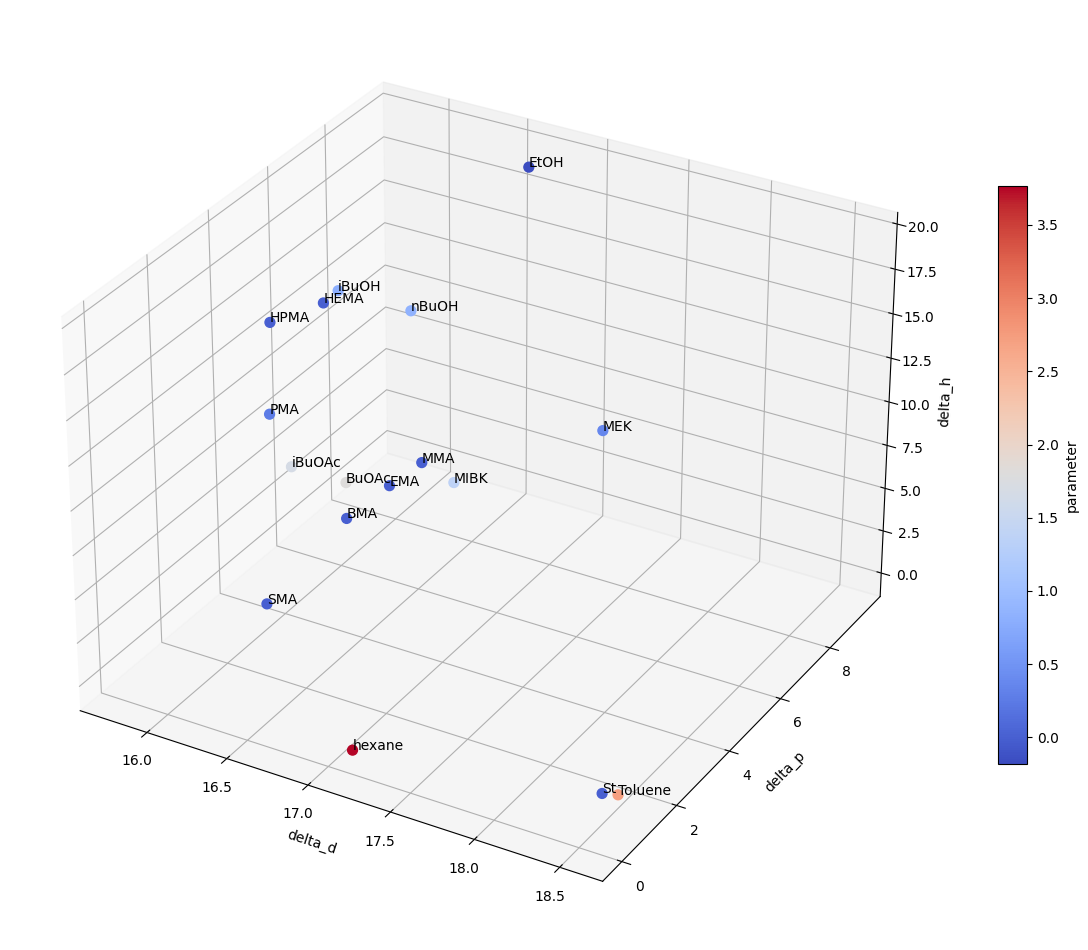

In [3]:
from modules import function as fc
import PySimpleGUI as sg
from rdkit import Chem
import pubchempy as pcp
import csv
import pandas as pd

sg.theme("DarkBlack1")


#記述子名のリスト
properties = ["Tag","SMILES","MW","Density","MolVolume","delta_d","delta_p","delta_h","Parameter"]
columns_name = properties

#過去データの取得、またはデータテーブルの初期化
try :
    #過去データの取得,DF化
    material_df = pd.read_csv("CSV/kreveren_sp_monomer.csv",encoding = "shift-jis")
    past_tag = material_df["Tag"].tolist()
except:
    material_df = pd.DataFrame(columns = columns_name)
    material_df.to_csv("CSV/kreveren_sp_monomer.csv",index=False,encoding ="shift-jis")
    past_tag = pd.read_csv("CSV/kreveren_sp_monomer.csv")["Tag"].tolist()

#全体のレイアウト
layout = [[sg.Text('Krevelen SP', font=('Constantia',20,"bold"))],
          [sg.Frame("Main",[[sg.Text("化合物名 / SMILES",size=(20, 1)),
                             sg.Input(size=(50, 1), 
                                      key="-INPUT-",
                                      text_color='black',
                                      background_color='honeydew'
                                     )],
                             [sg.Text("タグ",size=(20, 1)),
                              sg.Input(size=(50, 1),key = "Tag" ,
                                       text_color='black',
                                       background_color='honeydew')],
                            [sg.Radio('CAS or NAME',default=True, key="-1-", group_id='0'),
                             sg.Radio('SMILES',default=False, key="-2-", group_id='0')],
                            [sg.Text("")],
                            [sg.Button("実行",size=(10,1)),
                             sg.Button("記録",size=(10,1)),
                             sg.Button("読込み",size=(10,1)),
                             sg.Button("削除",size=(10,1))],
                            [sg.Button("SP距離マッピング",size=(22,1)),
                             sg.Button("SP空間散布図",size=(22,1))],
                            [sg.Text("")],
                            [sg.Image("images/mol_structure.png",key="-IMAGE-")],

                            [sg.Text("Parameter",size=(20, 1)),
                             sg.Input("0",
                                      size=(20, 1),
                                      key = "parameter",
                                      text_color='black',
                                      background_color='honeydew'
                                     )],
                            
                            [sg.Text("SMILES",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "SMILES")],
                            [sg.Text("MW (g/mol)",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "MW")],
                            [sg.Text("Density (g/cm3)",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "dens")],
                            [sg.Text("MolVolume",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "MolVolume")],
                            [sg.Text("delta_d",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "delta_d")],
                            [sg.Text("delta_p",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "delta_p")],
                            [sg.Text("delta_h",size=(20, 1)),
                             sg.Text("",size=(60, 1),key = "delta_h")],
                            
                           ]),
           sg.Frame("記録データ表",
                    [[sg.Table(headings=material_df.columns.to_list(),
                               values=material_df.to_numpy().tolist(),
                               auto_size_columns=False,
                               col_widths=[10] * len(material_df.columns),
                               key="output_table",
                               display_row_numbers=True,
                               vertical_scroll_only = False,
                               num_rows=min(30, 30))]],
                    vertical_alignment="top")]]

# モニターの解像度を取得
screen_width, screen_height = sg.Window.get_screen_size()

# ウィンドウのサイズをモニターの全画面に設定
window_size = (screen_width, screen_height)

# ウインドウの出現位置を指定
win_location = (0, 0)
window = sg.Window("Monomers", 
                   layout, 
                   size=window_size,
                   resizable=True,
                   location=win_location)

while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED:
        break
    if event == "実行":
        try: 
            if values['-1-'] == True:         
                    input_val = values["-INPUT-"]
                    results = pcp.get_compounds(input_val, 'name')
                    compound = results[0]
                    smiles = compound.canonical_smiles
                
            elif values['-2-'] == True:
                input_val = values["-INPUT-"]
                smiles = input_val
    

      
            #画像の更新
            fc.save_img(smiles)
            #smilesからsp推算クラス実行

            ksp= fc.Krevelen_sp(smiles)
            mw = ksp.mw
            vol = ksp.vol
            dens= ksp.mw/ksp.vol
            count = ksp.count
            
            delta_d = ksp.results['delta_d']
            delta_p = ksp.results['delta_p']
            delta_h = ksp.results['delta_h']
            parameter = values["parameter"]
            
            # 画像をウィンドウ内のsg.Imageコンポーネントに更新
            window["-IMAGE-"].update("images/mol_structure.png")
            
            #各パラメータの更新
            window["SMILES"].update(f"{smiles}")
            window["MW"].update(f"{mw}")
            window["dens"].update(f"{dens}")
            window["MolVolume"].update(f"{vol}")
            window["delta_d"].update(f"{delta_d}")
            window["delta_p"].update(f"{delta_p}")
            window["delta_h"].update(f"{delta_h}")
            window["parameter"].update(f"{parameter}")

        except:
            pass
            
    if event == "記録":

        #Parameterの更新
        parameter = values["parameter"]
        
        #追加データ行の作製
        if values["Tag"] !="":
            tag = values["Tag"] #TagがあるときはTag名に
        else:
            tag = values["-INPUT-"] #入力がない時はINPUTを適用
            
        new_row = [tag,smiles,mw,dens,vol,delta_d,delta_p,delta_h,parameter]
        new_row_df = pd.DataFrame([new_row],columns = columns_name)


        #既存データの場合
        if tag in material_df["Tag"].tolist():
            #読み取ったデータを該当の行に更新
            #行の初期化
            for elem in list(material_df.columns)[1:]:
                material_df.loc[material_df["Tag"] ==tag, elem] =0
            #要素の更新
            for elem in list(material_df.columns)[1:]:
                material_df.loc[material_df["Tag"] ==tag, elem] = new_row_df.iloc[0][elem]
        
        #新規データの場合
        else:    
            material_df = pd.concat([material_df,new_row_df])
            #Windowテーブルの更新
        window["output_table"].update(material_df.to_numpy().tolist())
        material_df.to_csv("CSV/kreveren_sp_monomer.csv",index=False,encoding ="shift-jis")
        
    if event == "削除":
        delete_Tag = values["Tag"]
        if delete_Tag in material_df["Tag"].to_list(): 
            material_df = material_df[material_df["Tag"] != delete_Tag]
            material_df = material_df[material_df["Tag"] != False ]
            past_tag2 = material_df["Tag"].to_numpy()
            window["output_table"].update(material_df.to_numpy().tolist())
            material_df.to_csv("CSV/kreveren_sp_monomer.csv",index=False,encoding ="shift-jis")

    if event == "読込み":
        Read_Name = values["Tag"]
        if Read_Name in material_df["Tag"].to_list():        
            target_row =material_df[material_df["Tag"] == Read_Name]
            #ターゲット行のSMILES取得
            smiles = target_row["SMILES"].to_numpy()[0]
            parameter = target_row["Parameter"].to_numpy()[0]
            window["-INPUT-"].update(smiles)
            window["-2-"].update(True)
            
            #画像の更新
            fc.save_img(smiles)
            #smilesからsp推算クラス実行
            ksp= fc.Krevelen_sp(smiles)
            mw = ksp.mw
            vol = ksp.vol
            dens= ksp.mw/ksp.vol
            
            delta_d = ksp.results['delta_d']
            delta_p = ksp.results['delta_p']
            delta_h = ksp.results['delta_h']

            # 画像をウィンドウ内のsg.Imageコンポーネントに更新
            window["-IMAGE-"].update("images/mol_structure.png")
            
            #各パラメータの更新
            window["SMILES"].update(f"{smiles}")
            window["MW"].update(f"{mw}")
            window["dens"].update(f"{dens}")
            window["MolVolume"].update(f"{vol}")
            window["delta_d"].update(f"{delta_d}")
            window["delta_p"].update(f"{delta_p}")
            window["delta_h"].update(f"{delta_h}")
            window["parameter"].update(f"{parameter}")
            
    if event == "SP空間散布図":
        
        tag = material_df["Tag"].tolist()
        x = material_df["delta_d"].tolist()
        y = material_df["delta_p"].tolist()
        z = material_df["delta_h"].tolist()
        p = material_df["Parameter"].to_numpy()

        
        fc.scatter3d(x,y,z,p,tag)

    if event == "SP距離マッピング":
        
        tag = material_df["Tag"].tolist()
        x = material_df["delta_d"].to_numpy()
        y = material_df["delta_p"].to_numpy()
        z = material_df["delta_h"].to_numpy()


        fc.sp_distance_map(x,y,z,tag)


window.close()

In [5]:
parameter

''